In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from lux.lux import LUX
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

/home/sbk/PycharmProjects/lux-experimental/src/lux/pyuid3/tree.py:427: SyntaxWarning: invalid escape sequence '\d'
  numbers = re.findall("[-]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", value_tr)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Iris example

In [51]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
iris = datasets.load_iris()
features = ['sepal_length','sepal_width','petal_length','petal_width']
target = 'calss'
rs=42
fraction=0.1

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_iris = pd.DataFrame(iris.data,columns=features)
df_iris[target] = iris.target

#train classifier
train, test = train_test_split(df_iris, random_state=rs)
clf = MLPClassifier(random_state=rs)# svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

1.0

## Withoiut uncertainty of predictor 

In [52]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
def noproba_predictor(x):
    preds = clf.predict_proba(x)
    hot = np.argmax(preds,axis=1)
    result = np.zeros(preds.shape)
    for i in range(0,len(result)):
        result[i,hot[i]] = 1
    return result

lux = LUX(predict_proba = lambda x: noproba_predictor(x), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2],n_jobs=1)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF sepal_width >=3.3000000715255737 THEN class = 0 # 1.0\n']

In [53]:
lux.counterfactual(np.array(iris_instance), train[features], counterfactual_representative='nearest', topn=1)

[{'rule': {'petal_length': ['<4.299999952316284'],
   'sepal_width': ['<3.3000000715255737']},
  'prediction': '1',
  'confidence': 1.0,
  'covered':     sepal_length  sepal_width  petal_length  petal_width
  81           5.5          2.4           3.7          1.0
  96           5.7          2.9           4.2          1.3
  67           5.8          2.7           4.1          1.0
  60           5.0          2.0           3.5          1.0
  94           5.6          2.7           4.2          1.3
  95           5.7          3.0           4.2          1.2
  62           6.0          2.2           4.0          1.0
  53           5.5          2.3           4.0          1.3
  93           5.0          2.3           3.3          1.0
  80           5.5          2.4           3.8          1.1
  98           5.1          2.5           3.0          1.1
  89           5.5          2.5           4.0          1.3
  61           5.9          3.0           4.2          1.5
  79           5.7        

In [54]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.6052631578947368


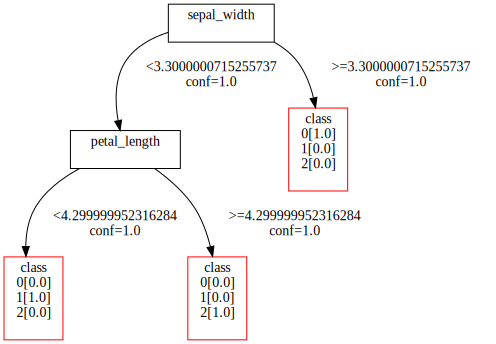

In [55]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance')

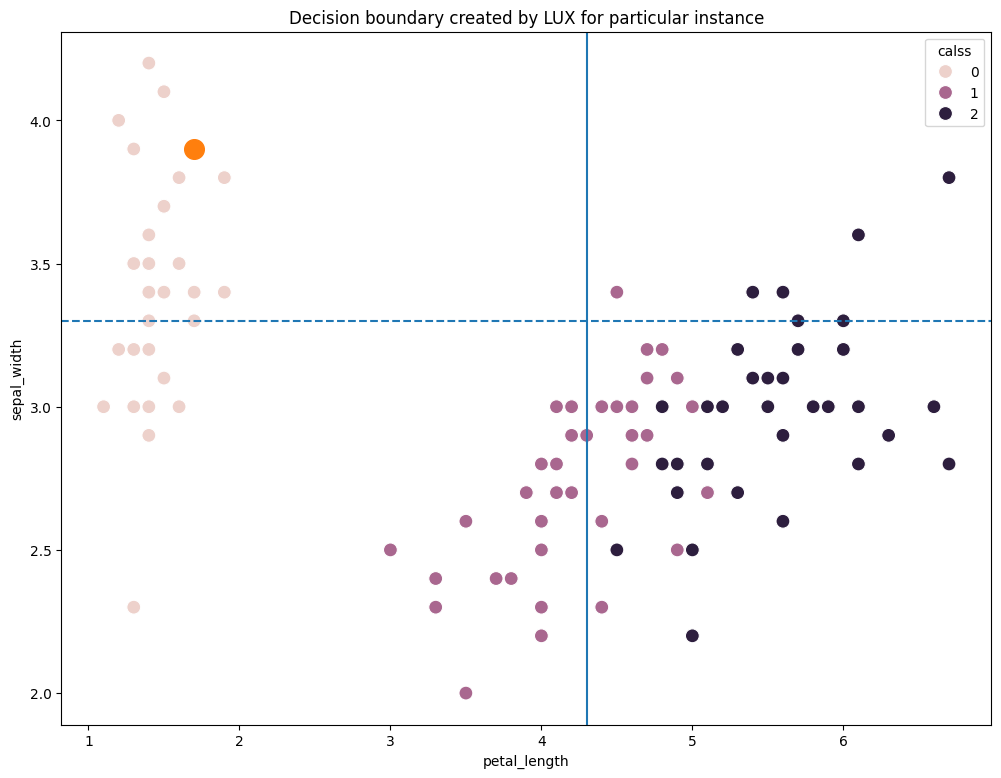

In [56]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='petal_length',y='sepal_width', data=train[['petal_length','sepal_width', target]],hue=target,s=100)
graph.axhline(3.3,0, linestyle='--')
graph.axvline(4.3)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='petal_length',y='sepal_width', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance')

### Without SHAP support

In [61]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF sepal_width >=3.3000000715255737 THEN class = 0 # 1.0\n']

In [62]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.6052631578947368


In [63]:
#have a look at the entire rule-based model that can be executed with https:://heartdroid.re
print(lux.to_HMR())

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TYPES DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%%%

xtype [
 name: petal_length, 
base:numeric,
domain : [-100000 to 100000]].
xtype [
 name: class, 
base:symbolic,
 domain : [2,1,0]].
xtype [
 name: sepal_width, 
base:numeric,
domain : [-100000 to 100000]].

%%%%%%%%%%%%%%%%%%%%%%%%% ATTRIBUTES DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%%%
xattr [ name: petal_length,
 type:petal_length,
 class:simple,
 comm:out ].
xattr [ name: class,
 type:class,
 class:simple,
 comm:out ].
xattr [ name: sepal_width,
 type:sepal_width,
 class:simple,
 comm:out ].

%%%%%%%%%%%%%%%%%%%%%%%% TABLE SCHEMAS DEFINITIONS %%%%%%%%%%%%%%%%%%%%%%%%
 xschm tree : [petal_length,sepal_width]==> [class].
xrule tree/0:
[petal_length  lt 4.299999952316284, sepal_width  lt 3.3000000715255737] ==> [class set 1]. # 1.0
xrule tree/1:
[petal_length  gte 4.299999952316284, sepal_width  lt 3.3000000715255737] ==> [class set 2]. # 1.0
xrule tree/2:
[sepal_width  gte 3.3000000715255737] ==> [class set 0]. #

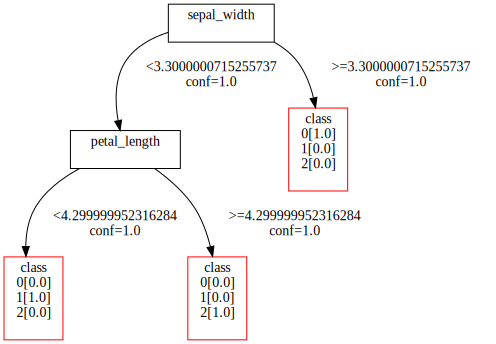

In [64]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

## In fact, the explanation above is overcomplicated
The explanation can be made only using petal_lenght, but due to the greadiness of decision tree classifier, algorithm could not select correct split criterion for the fist place

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance')

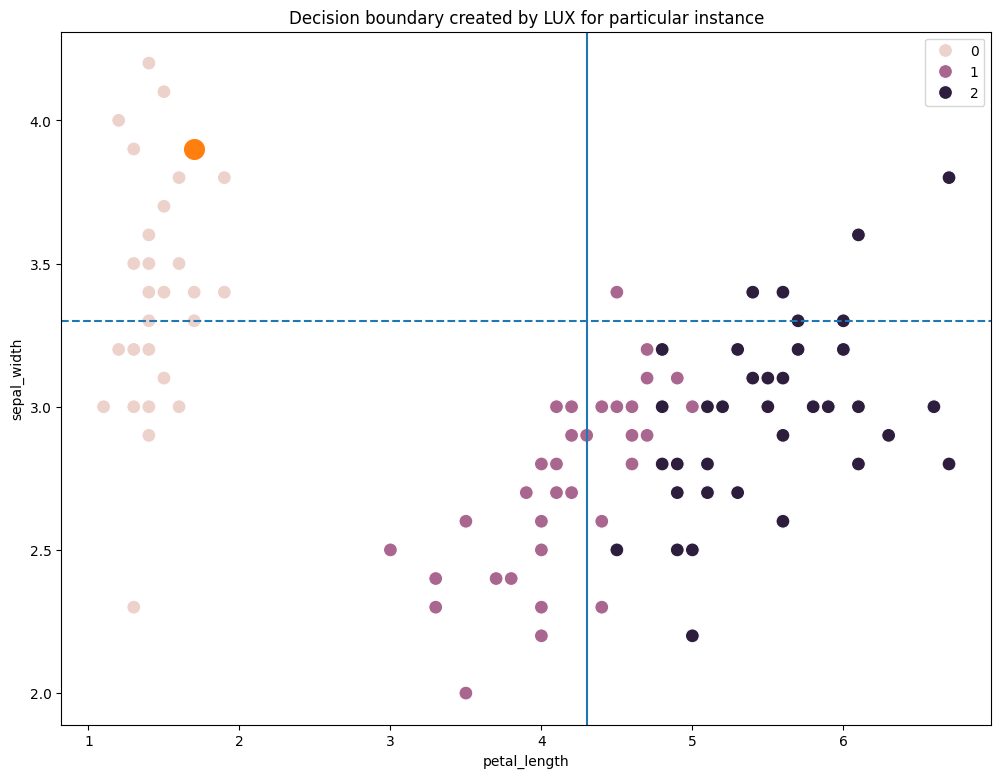

In [12]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='petal_length',y='sepal_width', data=train[['petal_length','sepal_width', target]],hue=clf.predict(train[features]),s=100)
graph.axhline(3.3,0, linestyle='--')
graph.axvline(4.3)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='petal_length',y='sepal_width', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance')

## Iris example with SHAP values
The explanation is more compact, and more consistend with the model, hence, the LUX tree with SHAP support obtains more accuray on the whole dataset, wing smaller than LUX tree without SHAP support

In [13]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
iris = datasets.load_iris()
features = ['sepal_length','sepal_width','petal_length','petal_width']
target = 'calss'

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_iris = pd.DataFrame(iris.data,columns=features)
df_iris[target] = iris.target

#train classifier
train, test = train_test_split(df_iris, random_state=rs)
clf = svm.SVC(probability=True,random_state=rs)
clf.fit(train[features].values,train[target])
clf.score(test[features].values,test[target])

1.0

In [14]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(clf.predict_proba, train[features])
shap_values = explainer.shap_values(train[features])

Using 112 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:02<00:00, 53.24it/s]


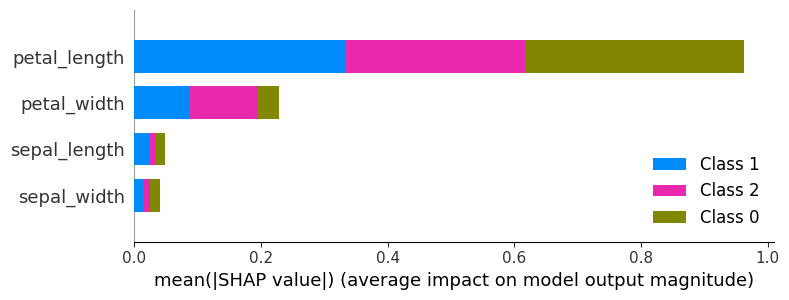

In [15]:
shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None)

In [16]:
#train lux on neighbourhood equal 30% instances
import warnings
warnings.filterwarnings('ignore')
lux = LUX(predict_proba = clf.predict_proba,classifier=clf, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = None,  instance_to_explain=iris_instance,class_names=[0,1,2],discount_importance=True)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF petal_length <2.449999988079071 THEN class = 0 # 1.0\n']

In [17]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9210526315789473


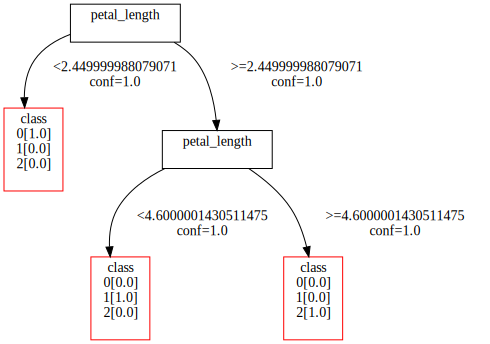

In [18]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

In [19]:
clf.predict_proba(train[features]).max(axis=1)

array([0.97118103, 0.97210299, 0.89006079, 0.88160302, 0.81786984,
       0.97045493, 0.96319465, 0.97585871, 0.65514522, 0.94599667,
       0.94444461, 0.98463087, 0.9644418 , 0.98306401, 0.85926659,
       0.96860788, 0.98123151, 0.97859169, 0.96536328, 0.97171228,
       0.93400597, 0.96670566, 0.67679076, 0.93160476, 0.94102863,
       0.92848546, 0.95927648, 0.96124893, 0.96953995, 0.9759809 ,
       0.96598352, 0.96212385, 0.89473994, 0.97087179, 0.53694441,
       0.89006079, 0.98076052, 0.84356394, 0.96891032, 0.96636796,
       0.94811746, 0.94251749, 0.93552155, 0.96549786, 0.97183409,
       0.97799824, 0.61158174, 0.95437357, 0.96191713, 0.96253193,
       0.94394846, 0.50244814, 0.88042867, 0.98253759, 0.76006572,
       0.93518193, 0.98155629, 0.9698558 , 0.95757548, 0.97445461,
       0.69867135, 0.97702967, 0.9572548 , 0.96653373, 0.96605836,
       0.50183859, 0.98304963, 0.96825211, 0.96851318, 0.99035486,
       0.9700016 , 0.8060617 , 0.83695774, 0.56047144, 0.86810

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance with SHAP support')

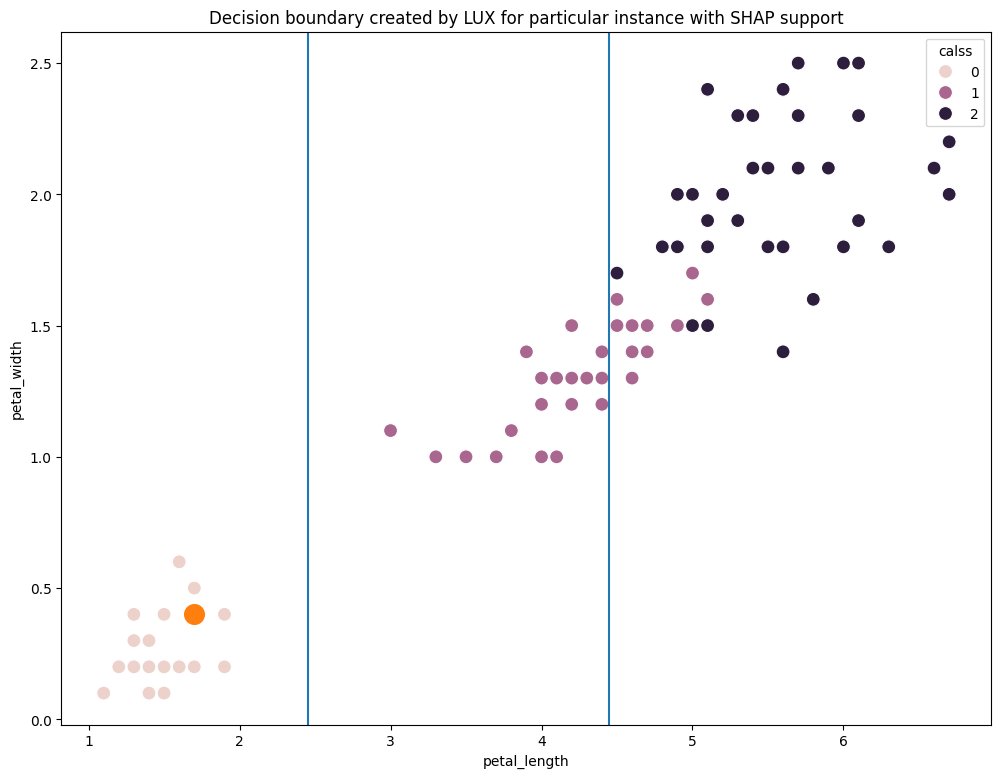

In [20]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='petal_length',y='petal_width', data=train[['petal_length','petal_width',target]],hue=target,s=100)
graph.axvline(2.45)
graph.axvline(4.45)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='petal_length',y='petal_width', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance with SHAP support')

# Wine example

In [21]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
wine = datasets.load_wine()

In [22]:
features = wine['feature_names']
target = 'calss'
rs=42

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_wine = pd.DataFrame(wine.data,columns=features)
df_wine[target] = wine.target

#train classifier
train, test = train_test_split(df_wine, random_state=rs)
clf = RandomForestClassifier(random_state=42)#svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

1.0

## Without predictor uncertainty

In [23]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF color_intensity >=3.9499999284744263 AND proline <715.0 THEN class = 2 # 0.8666666666666668\n']

In [24]:
#calculate decision tree score over this dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.8222222222222222


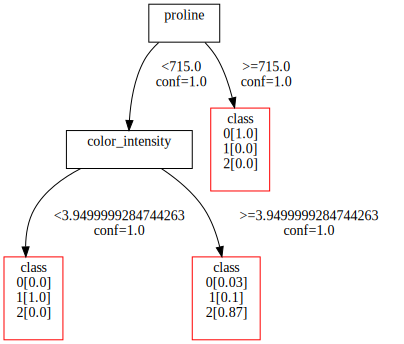

In [25]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

## Without SHAP

In [26]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 20 instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF color_intensity >=3.5749999284744263 AND od280/od315_of_diluted_wines <2.2050000429153442 THEN class = 2 # 1.0\n']

In [27]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9555555555555556


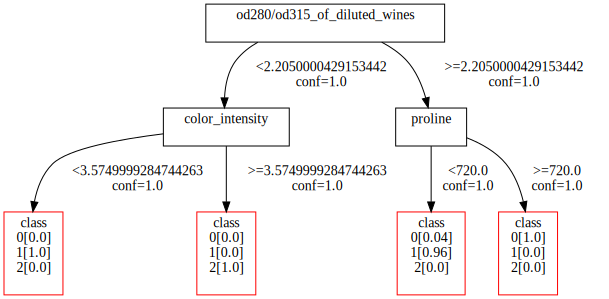

In [28]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance without SHAP support')

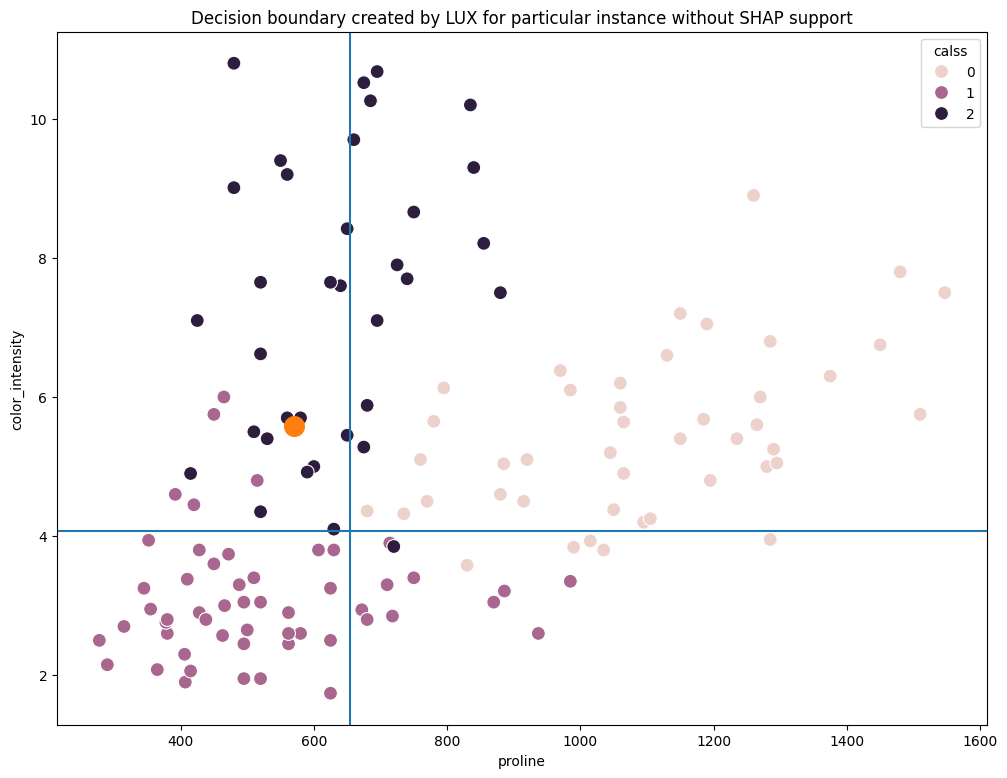

In [29]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='proline',y='color_intensity', data=train[['proline','color_intensity',target]],hue=target,s=100)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='proline',y='color_intensity', marker='o', s=200)
graph.axhline(4.07)
graph.axvline(655)
plt.title('Decision boundary created by LUX for particular instance without SHAP support')

## With SHAP

In [30]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(clf, train[features])
shap_values = explainer.shap_values(train[features],check_additivity=False)

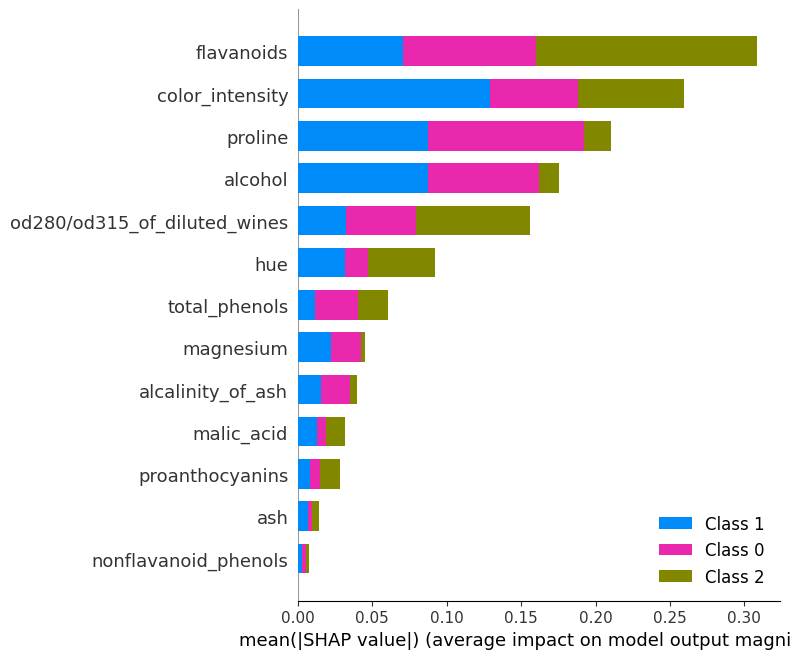

In [31]:
shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None)

In [32]:
#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, classifier=clf, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = None,  instance_to_explain=iris_instance,class_names=[0,1,2],discount_importance=True)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF flavanoids <2.3049999475479126 AND color_intensity >=3.9499999284744263 THEN class = 2 # 1.0\n']

In [33]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9555555555555556


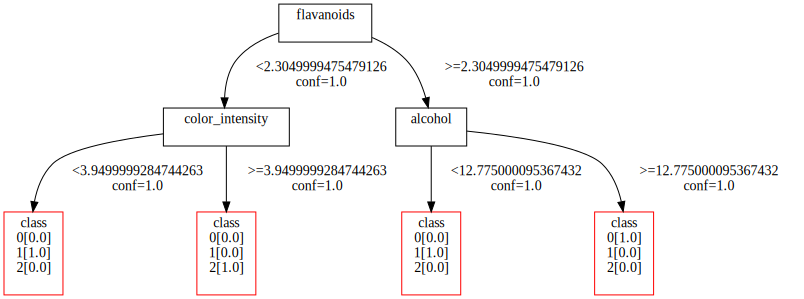

In [34]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance SHAP support')

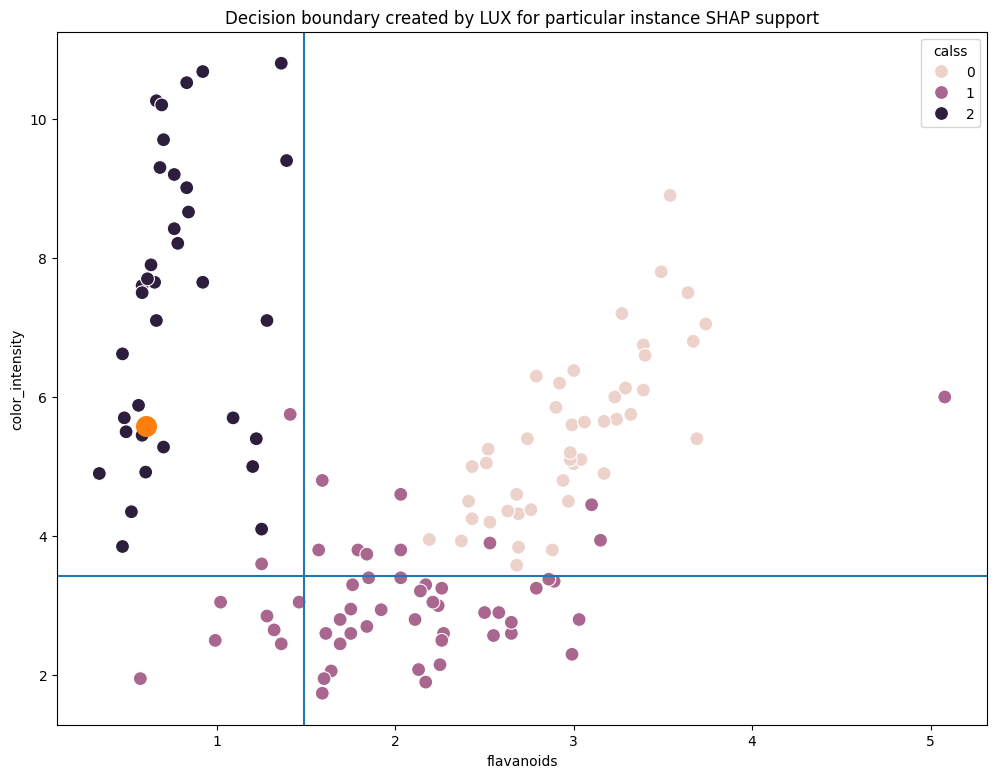

In [35]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='flavanoids',y='color_intensity', data=train[['flavanoids','color_intensity',target]],hue=target,s=100)
graph.axvline(1.49)
graph.axhline(3.425)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='flavanoids',y='color_intensity', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance SHAP support')

# Breast cancer

In [36]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
cancer = datasets.load_breast_cancer()

In [37]:
features = [f.replace(" ","_") for f in cancer['feature_names']]
target = 'calss'
rs=42

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_cancer = pd.DataFrame(cancer.data,columns=features)
df_cancer[target] = cancer.target

#train classifier
train, test = train_test_split(df_cancer, random_state=rs)
clf = RandomForestClassifier(random_state=42)#svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

0.965034965034965

## Without predictor uncertinaty

In [38]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF worst_area <750.0499877929688 AND worst_concave_points <0.15839999914169312 THEN class = 1 # 0.9444444444444444\n']

In [39]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9020979020979021


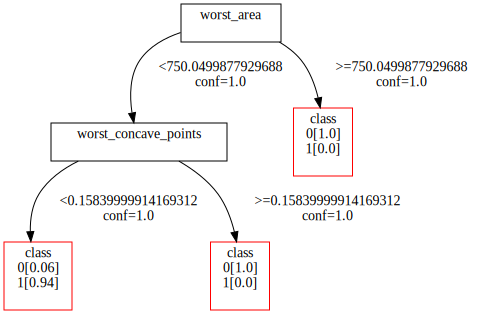

In [40]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

## Without SHAP

In [41]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF worst_area <750.0499877929688 AND mean_compactness <0.16804999858140945 THEN class = 1 # 0.9882352941176471\n']

In [42]:
#calculate decision tree score over this dataset

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9090909090909091


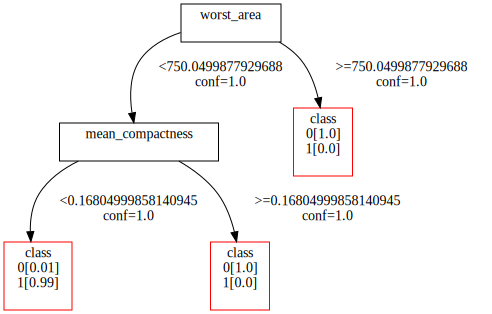

In [43]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance without SHAP support')

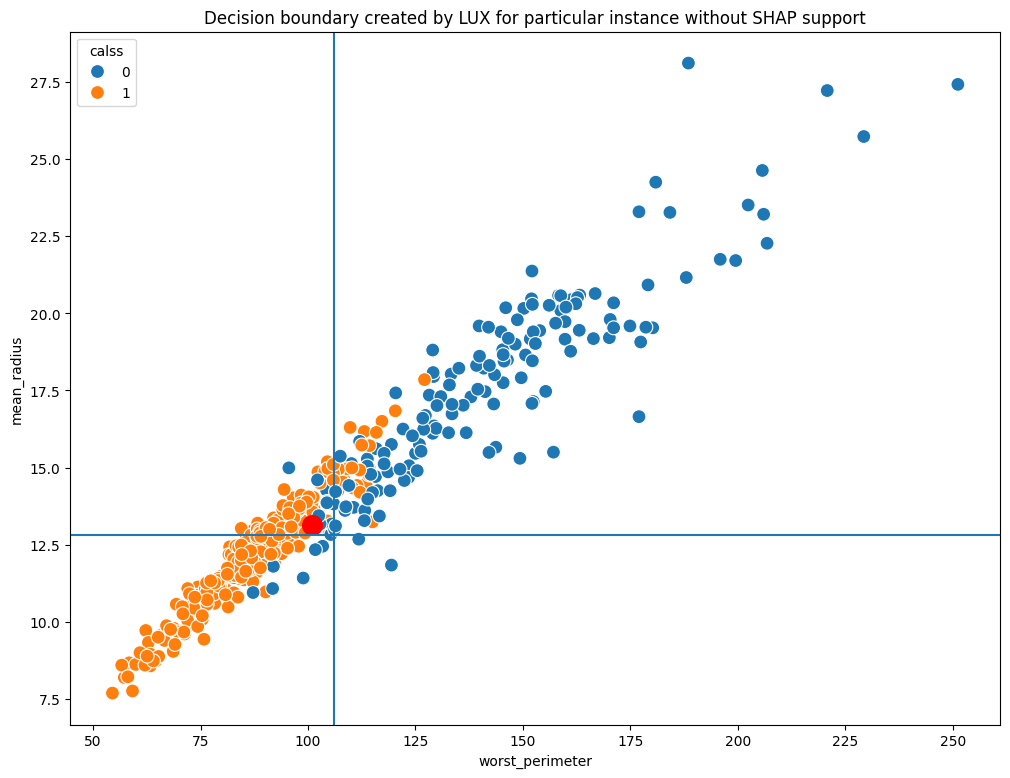

In [44]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='worst_perimeter',y='mean_radius', data=train[['worst_perimeter','mean_radius',target]],hue=target,s=100)
graph.axvline(105.95)
graph.axhline(12.8)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='worst_perimeter',y='mean_radius', marker='o',color='r', s=200)
plt.title('Decision boundary created by LUX for particular instance without SHAP support')

## With SHAP

In [45]:
import shap
shap.initjs()
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees


explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(train[features],check_additivity=True)

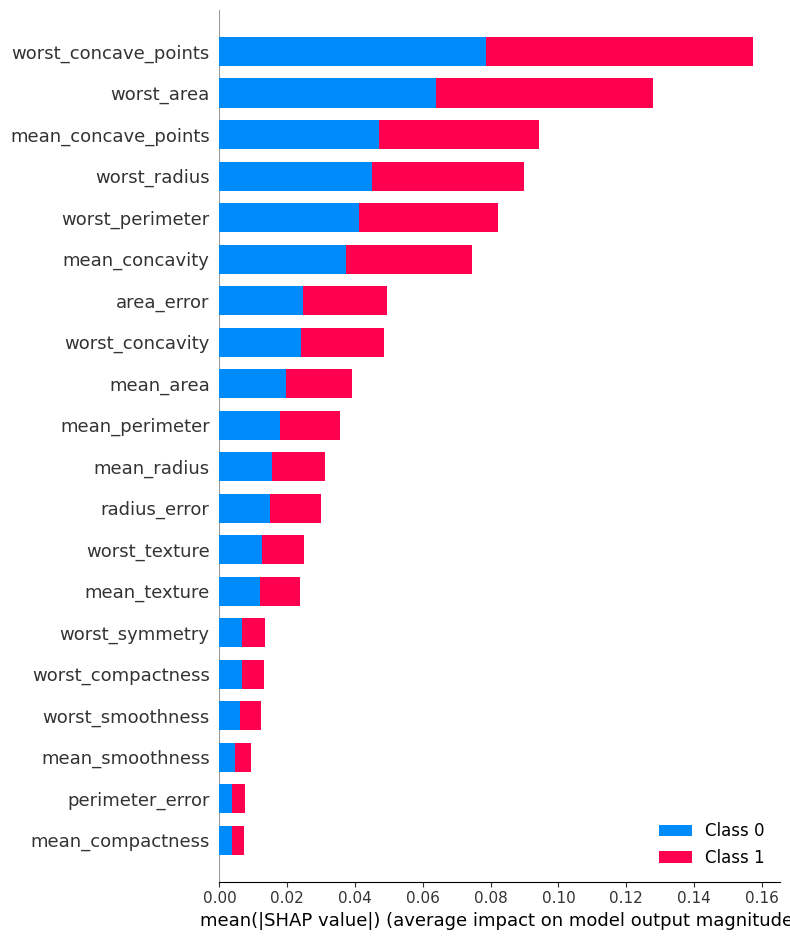

In [46]:
shap.summary_plot(shap_values,train[features])#, features=None, feature_names=features, max_display=None)

In [47]:
#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, classifier=clf, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = None,  instance_to_explain=iris_instance,class_names=[0,1],discount_importance=True)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

['IF worst_area <750.0499877929688 AND mean_compactness <0.16804999858140945 THEN class = 1 # 0.9882352941176471\n']

In [48]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from lux.pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9090909090909091


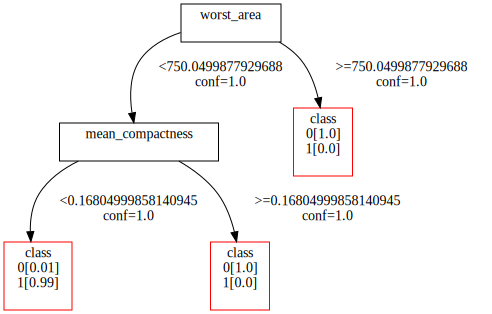

In [49]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

Text(0.5, 1.0, 'Decision boundary created by LUX for particular instance with SHAP support')

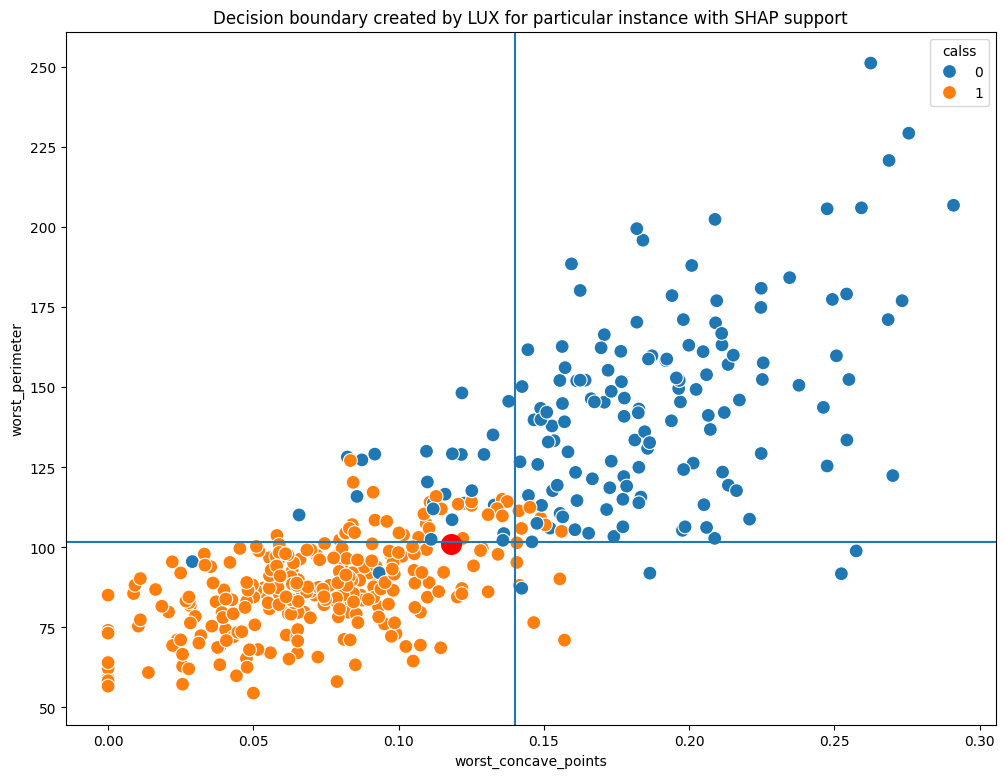

In [50]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='worst_concave_points',y='worst_perimeter', data=train[['worst_concave_points','worst_perimeter',target]],hue=target,s=100)
graph.axvline(0.14)
graph.axhline(101.8)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='worst_concave_points',y='worst_perimeter', marker='o',color='r', s=200)
plt.title('Decision boundary created by LUX for particular instance with SHAP support')